In [1]:
#Imports
import gc
import numpy as np
import pandas as pd
from time import time
from datetime import timedelta, date

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import calendar as cal

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score;
from sklearn.decomposition import TruncatedSVD
import statsmodels.formula.api as smf
import pickle

/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [11]:
hd = pd.read_csv("../data/sales/holidays_events.csv")
it = pd.read_csv("../data/sales/items.csv")
oil = pd.read_csv("../data/sales/oil.csv", parse_dates=['date'])
st = pd.read_csv("../data/sales/stores.csv")
tr = pd.read_csv("../data/sales/transactions.csv")
train = pd.read_csv("../data/sales/train.csv", skiprows=range(1,90000000), parse_dates=[1])
test = pd.read_csv("../data/sales/test.csv", parse_dates=['date'])

In [156]:
# todo merge holiday
# todo merge transactions

In [2]:
#helper functions 

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

def NWRMSLE(y, pred, w):
    y = y.clip(0, y.max())
    pred = pred.clip(0, pred.max())
    score = np.nansum(w * ((np.log1p(pred) - np.log1p(y)) ** 2)) / w.sum()
    return np.sqrt(score)

#add payday
def payday(df):
    if df['day'] == 15:
        return 1
    elif cal.monthrange(df['year'],df['month'])[1] == df['day']:
        return 1
    else: 
        return 0

#merge item    
def df_trans(df):
    df = pd.merge(df, it, how='left', on=['item_nbr']) 
    df['weekday'] = df['date'].dt.dayofweek 
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df.onpromotion = df.onpromotion.astype(int)
    df['perishable'] = df['perishable'].map({0:1, 1:1.25})
    df[['store_nbr']] = df[['store_nbr']].fillna(value=1)    
    df = df.fillna(-1)
    return df

def add_payday(df):
# is payday dataframe
    u_day = df.date.unique()
    u_day = pd.DataFrame(u_day)
    u_day.columns = ['date']
    u_day['day'] = u_day['date'].dt.day
    u_day['month'] = u_day['date'].dt.month
    u_day['year'] = u_day['date'].dt.year
    u_day['is_payday'] = u_day.apply(payday, axis=1)
    u_day.drop(['day','month','year'], axis=1, inplace=True)
    df= df.merge(u_day,how='left', on=['date'])
    return df

In [13]:
train = df_trans(train)
#test = pd.read_csv("../data/sales/test.csv", parse_dates=['date'])
test = df_trans(test)
df_2017 = train[train.date >= '2017-01-01']

# Feature Engineering 

In [14]:
cols = ['store_nbr','weekday','item_nbr','onpromotion']
mean_sale = df_2017.groupby(cols)['unit_sales'].mean()
mean_sale = mean_sale.reset_index()
mean_sale.rename(columns={'unit_sales': 'mean_sales'}, inplace=True)

In [15]:
#add mean_sales
df_2017 = df_2017.merge(mean_sale, how='left', on=['store_nbr', 'item_nbr', 'onpromotion', 'weekday'])
test = test.merge(mean_sale, how='left', on=['store_nbr', 'item_nbr', 'onpromotion', 'weekday'])

In [16]:
#add is_payday
df_2017 = add_payday(df_2017)
test = add_payday(test)

In [17]:
test.head(2)

,id,date,store_nbr,item_nbr,onpromotion,family,class,perishable,weekday,day,month,year,dayofyear,mean_sales,is_payday
0,125497040,2017-08-16,1,96995,0,GROCERY I,1093,1.0,2,16,8,2017,228,1.000000,0
1,125497041,2017-08-16,1,99197,0,GROCERY I,1067,1.0,2,16,8,2017,228,1.818182,0


In [18]:
df_2017[(df_2017['day']==30) & (df_2017['month']==4)]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,weekday,day,month,year,dayofyear,mean_sales,is_payday
12374056,114062835,2017-04-30,1,105574,2.0,0,GROCERY I,1045,1.00,6,30,4,2017,120,1.952381,1
12374057,114062836,2017-04-30,1,105575,4.0,0,GROCERY I,1045,1.00,6,30,4,2017,120,4.468750,1
12374058,114062837,2017-04-30,1,108079,1.0,0,GROCERY I,1030,1.00,6,30,4,2017,120,1.500000,1
12374059,114062838,2017-04-30,1,108786,1.0,0,CLEANING,3044,1.00,6,30,4,2017,120,2.391304,1
12374060,114062839,2017-04-30,1,108797,1.0,0,GROCERY I,1004,1.00,6,30,4,2017,120,1.928571,1
12374061,114062840,2017-04-30,1,111223,1.0,0,GROCERY I,1034,1.00,6,30,4,2017,120,4.689655,1
12374062,114062841,2017-04-30,1,114778,3.0,0,GROCERY I,1016,1.00,6,30,4,2017,120,3.000000,1
12374063,114062842,2017-04-30,1,114799,1.0,0,PERSONAL CARE,4126,1.00,6,30,4,2017,120,1.666667,1
12374064,114062843,2017-04-30,1,114800,1.0,0,PERSONAL CARE,4126,1.00,6,30,4,2017,120,2.210526,1
12374065,114062844,2017-04-30,1,115267,1.0,0,CLEANING,3034,1.00,6,30,4,2017,120,1.375000,1


In [19]:
df_2017.mean_sales.isnull().sum()


0

In [20]:
# mean_sales 888267 fill with mean for now, todo fill with similar item, similar location, similar date
test.mean_sales.isnull().sum()

888267

In [21]:
test.mean_sales.fillna(test.mean_sales.mean(), inplace=True)

In [22]:
#df_2017.drop(['dcoilwtico'], axis=1, inplace=True)
#test.drop(['dcoilwtico'], axis=1, inplace=True)

In [23]:
# merge oil

# todo try interpolate
#train['dcoilwtico'].interpolate(inplace=True, limit_direction='both')

oil.head()
oil.dcoilwtico.isnull().sum()

43

In [24]:
oil.dcoilwtico.fillna(method='ffill',inplace=True)

In [25]:
oil_date=[]
start_dt = date(2016, 12, 30)
end_dt = date(2017, 8, 31)
for dt in daterange(start_dt, end_dt):
    oil_date.append(dt.strftime("%Y-%m-%d"))

In [26]:
oil_date=pd.DataFrame(oil_date)
oil_date.columns=["date"]
oil_date['date']=oil_date['date'].astype('datetime64[ns]')


In [27]:
oil_date=oil_date.merge(oil,how='outer',on=['date'])

In [28]:
oil_date.dcoilwtico.fillna(method='ffill',inplace=True)

In [29]:
df_2017 = df_2017.merge(oil_date, how='left', on=['date'])
test = test.merge(oil_date, how='left', on=['date'])

In [30]:
test.dcoilwtico.isnull().sum()

0

In [31]:
df_2017.dcoilwtico.isnull().sum()

0

In [32]:
test.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
onpromotion    0
family         0
class          0
perishable     0
weekday        0
day            0
month          0
year           0
dayofyear      0
mean_sales     0
is_payday      0
dcoilwtico     0
dtype: int64

In [33]:
df_2017.isnull().sum()

id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
family         0
class          0
perishable     0
weekday        0
day            0
month          0
year           0
dayofyear      0
mean_sales     0
is_payday      0
dcoilwtico     0
dtype: int64

In [34]:
# merge store
df_2017= df_2017.merge(st,how='left', on=['store_nbr'])
test= test.merge(st,how='left', on=['store_nbr'])

In [35]:
df_2017.info()
df_2017.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23808261 entries, 0 to 23808260
Data columns (total 21 columns):
id             int64
date           datetime64[ns]
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    int64
family         object
class          int64
perishable     float64
weekday        int64
day            int64
month          int64
year           int64
dayofyear      int64
mean_sales     float64
is_payday      int64
dcoilwtico     float64
city           object
state          object
type           object
cluster        int64
dtypes: datetime64[ns](1), float64(4), int64(12), object(4)
memory usage: 3.9+ GB


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,weekday,...,month,year,dayofyear,mean_sales,is_payday,dcoilwtico,city,state,type,cluster
0,101688779,2017-01-01,25,99197,1.0,0,GROCERY I,1067,1.00,6,...,1,2017,1,1.375000,0,53.75,Salinas,Santa Elena,D,1
1,101688780,2017-01-01,25,103665,7.0,0,BREAD/BAKERY,2712,1.25,6,...,1,2017,1,3.148148,0,53.75,Salinas,Santa Elena,D,1
2,101688781,2017-01-01,25,105574,1.0,0,GROCERY I,1045,1.00,6,...,1,2017,1,2.708333,0,53.75,Salinas,Santa Elena,D,1
3,101688782,2017-01-01,25,105857,4.0,0,GROCERY I,1092,1.00,6,...,1,2017,1,2.176471,0,53.75,Salinas,Santa Elena,D,1
4,101688783,2017-01-01,25,106716,2.0,0,GROCERY I,1032,1.00,6,...,1,2017,1,3.000000,0,53.75,Salinas,Santa Elena,D,1


In [36]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3370464 entries, 0 to 3370463
Data columns (total 20 columns):
id             int64
date           datetime64[ns]
store_nbr      int64
item_nbr       int64
onpromotion    int64
family         object
class          int64
perishable     float64
weekday        int64
day            int64
month          int64
year           int64
dayofyear      int64
mean_sales     float64
is_payday      int64
dcoilwtico     float64
city           object
state          object
type           object
cluster        int64
dtypes: datetime64[ns](1), float64(3), int64(12), object(4)
memory usage: 540.0+ MB


,id,date,store_nbr,item_nbr,onpromotion,family,class,perishable,weekday,day,month,year,dayofyear,mean_sales,is_payday,dcoilwtico,city,state,type,cluster
0,125497040,2017-08-16,1,96995,0,GROCERY I,1093,1.00,2,16,8,2017,228,1.000000,0,46.8,Quito,Pichincha,D,13
1,125497041,2017-08-16,1,99197,0,GROCERY I,1067,1.00,2,16,8,2017,228,1.818182,0,46.8,Quito,Pichincha,D,13
2,125497042,2017-08-16,1,103501,0,CLEANING,3008,1.00,2,16,8,2017,228,6.321907,0,46.8,Quito,Pichincha,D,13
3,125497043,2017-08-16,1,103520,0,GROCERY I,1028,1.00,2,16,8,2017,228,2.320000,0,46.8,Quito,Pichincha,D,13
4,125497044,2017-08-16,1,103665,0,BREAD/BAKERY,2712,1.25,2,16,8,2017,228,3.185185,0,46.8,Quito,Pichincha,D,13


In [37]:
df_2017.drop(['year'], axis=1, inplace=True)
test.drop(['year'], axis=1, inplace=True)

In [38]:
df_2017.drop('dayofyear', axis=1, inplace=True)
test.drop('dayofyear', axis=1, inplace=True)

In [39]:
df_2017.set_index('id',inplace=True)
test.set_index('id',inplace=True)


In [187]:
test_tmp = test

In [40]:
df_2017.to_csv("df_2017.csv")
test.to_csv("df_2017_test.csv")

# EDA

In [27]:
df_2017.corr().unit_sales

store_nbr      0.044939
item_nbr       0.023832
unit_sales     1.000000
onpromotion    0.083505
class         -0.051218
perishable     0.060205
weekday        0.027685
day           -0.012678
month         -0.001791
dayofyear     -0.003535
mean_sales     0.773544
is_payday      0.000170
dcoilwtico     0.006593
cluster        0.021916
Name: unit_sales, dtype: float64

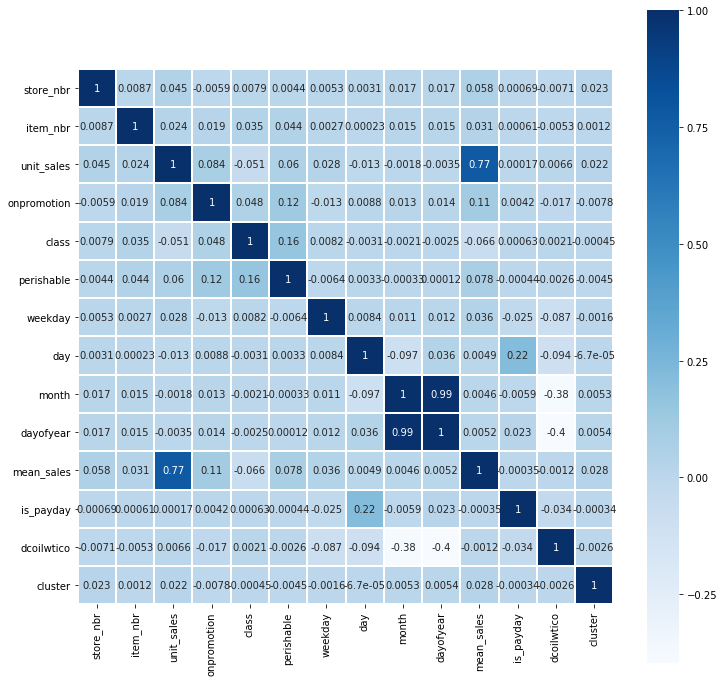

In [28]:
plt.figure(figsize=(12,12))
sns.heatmap(df_2017.corr(), annot=True,  cmap="Blues", square=1, linewidth=1.)


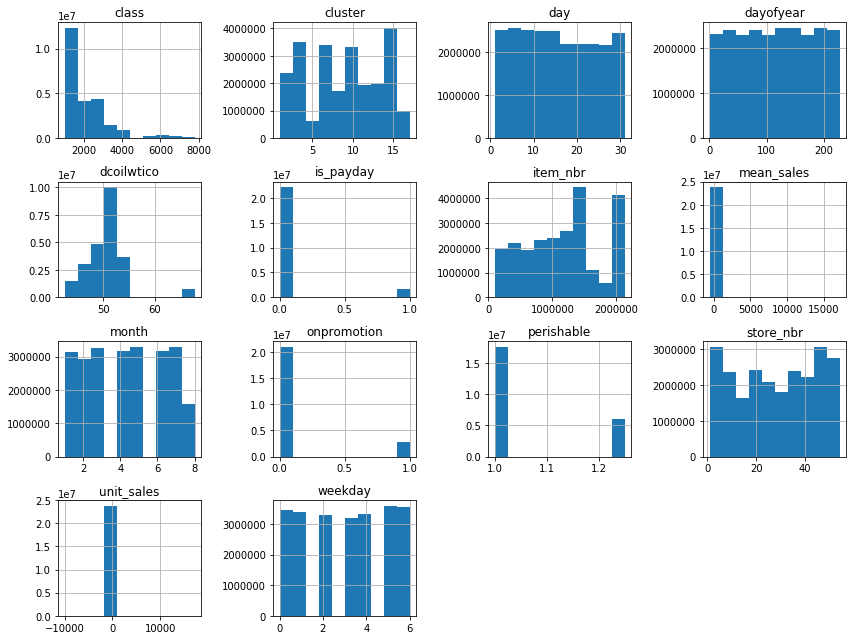

In [29]:
df_2017.hist(figsize=(12,9))
plt.tight_layout()
plt.show()

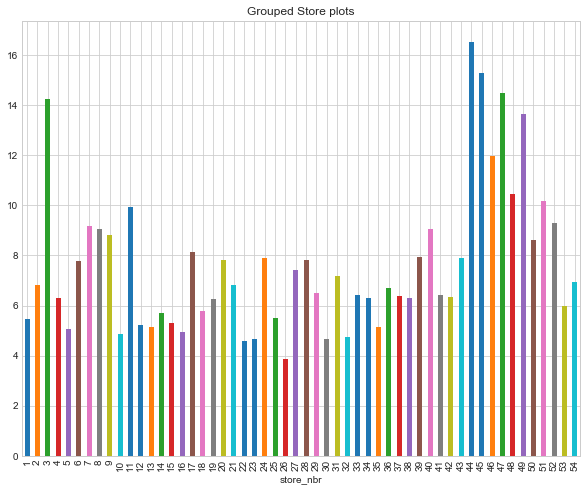

In [73]:
df_2017.groupby("store_nbr")['unit_sales'].mean().plot(kind="bar", figsize=(10,8), 
                                           title = "Grouped Store plots")
plt.show()

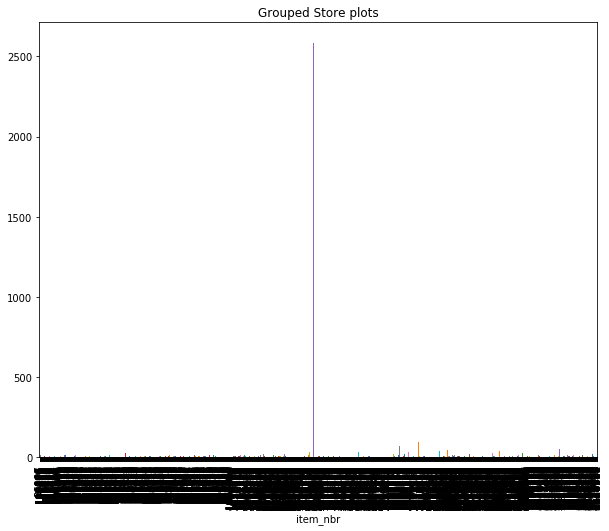

In [45]:
df_2017.groupby("item_nbr")['unit_sales'].mean().plot(kind="bar", figsize=(10,8), 
                                           title = "Grouped Store plots")
plt.show()

In [32]:
iu = df_2017.groupby("item_nbr")['unit_sales'].mean().reset_index()
iu.sort_values('unit_sales', ascending=False)

,item_nbr,unit_sales
1973,1239986,2582.738581
3411,1976284,1988.000000
1543,1084365,298.221217
2799,1503844,228.359650
719,583985,108.862382
1772,1167614,104.874130
3547,2006812,98.536738
3807,2042947,97.124161
2729,1473474,96.657232
3806,2042941,94.964476


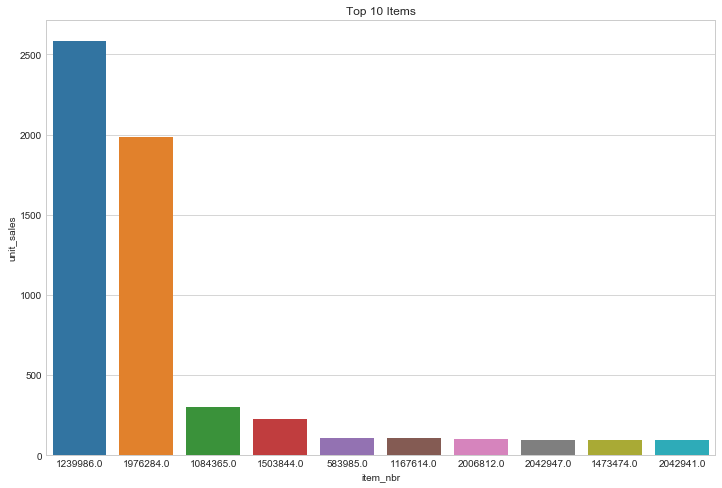

In [74]:
odr= []
for index, row in titm.iterrows():
    odr.append(row['item_nbr'])
   
titm = iu.sort_values('unit_sales', ascending=False).head(10)
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))
ax = sns.barplot(y='unit_sales',x="item_nbr", data=titm, order=odr).set_title("Top 10 Items")
plt.show()

In [63]:
it[it.item_nbr==1239986]
it[it.item_nbr==1976284]

,item_nbr,family,class,perishable
3434,1976284,MEATS,2302,1


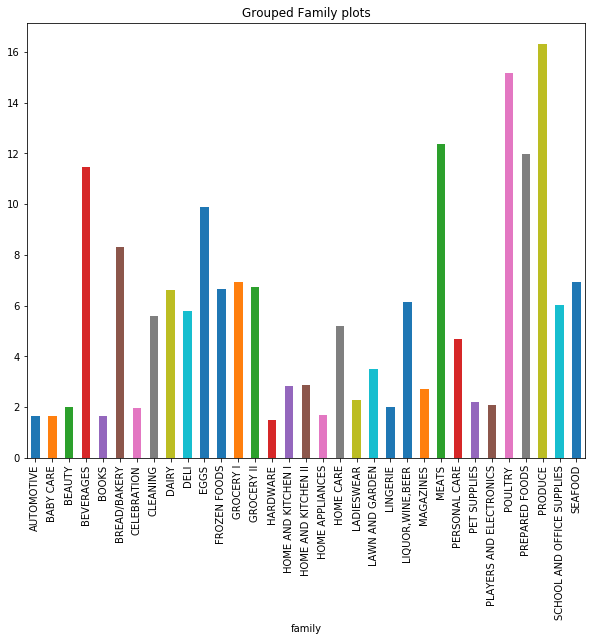

In [81]:
df_2017.groupby("family")['unit_sales'].mean().plot(kind="bar", figsize=(10,8), 
                                           title = "Grouped Family plots")
plt.show()

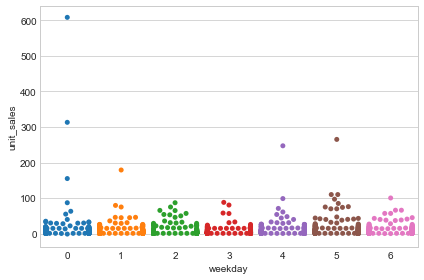

In [79]:
#plt.figure(figsize=(12,8))
df_1 =df_2017.sample(n=2000)
sns.swarmplot(x="weekday",y="unit_sales", data=df_1)
plt.show()

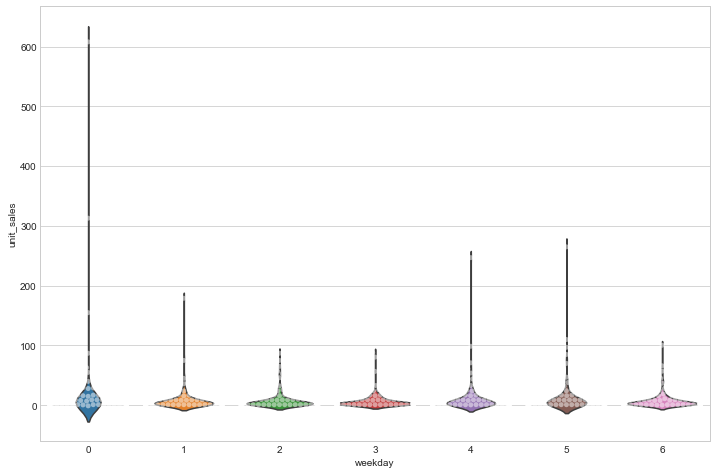

In [103]:
plt.figure(figsize=(12,8))

sns.violinplot(x="weekday",y="unit_sales", data=df_1, inner=None)
sns.swarmplot(x="weekday",y="unit_sales", data=df_1, color="w", alpha=.5)

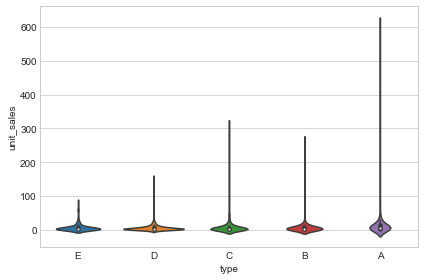

In [98]:
sns.violinplot(x="type",y="unit_sales", data=df_1)
plt.show()

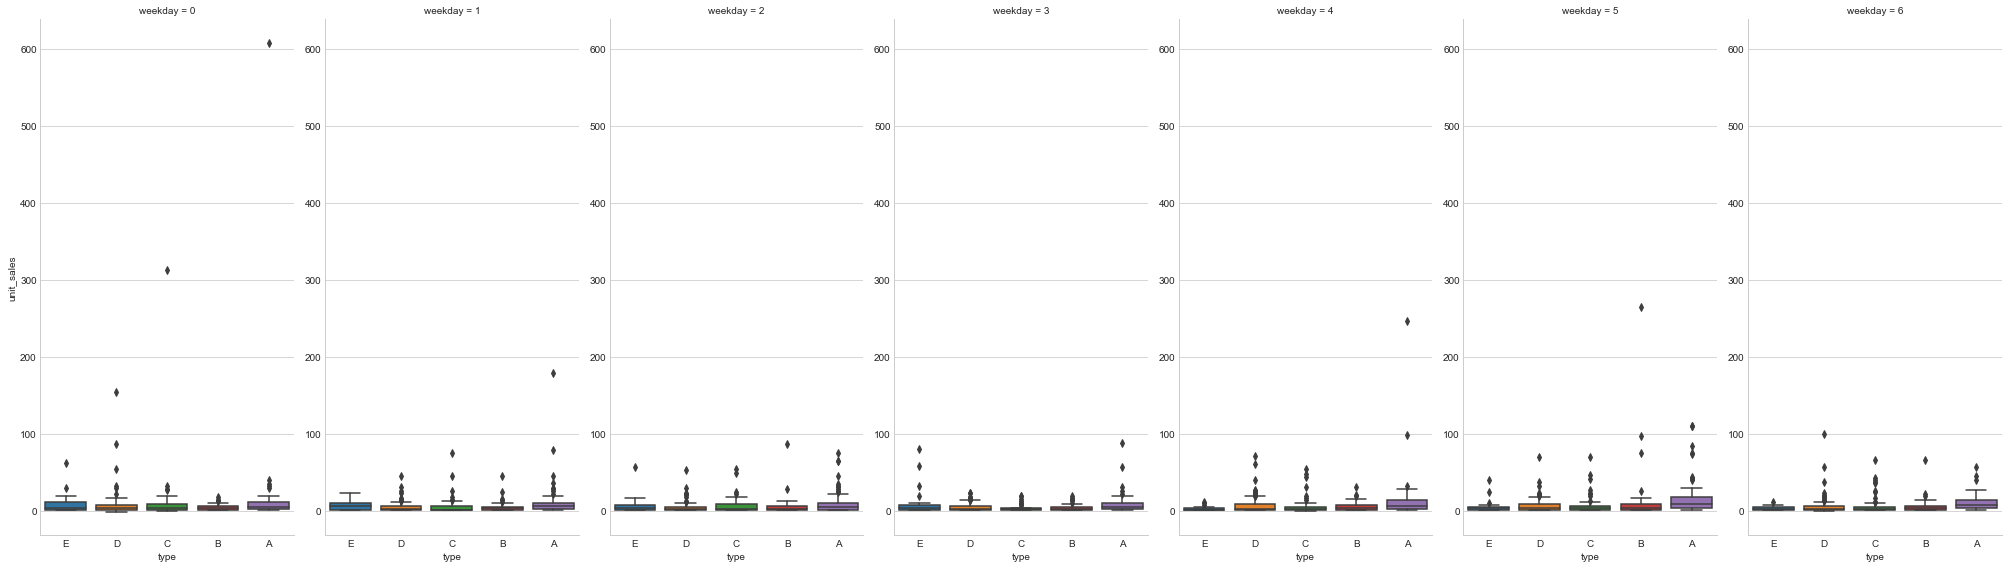

In [111]:
plt.figure(figsize=(12,8))
sns.factorplot(x="type",y="unit_sales", data=df_1, col="weekday", 
               kind="box", size=8, aspect=.5)
plt.show()

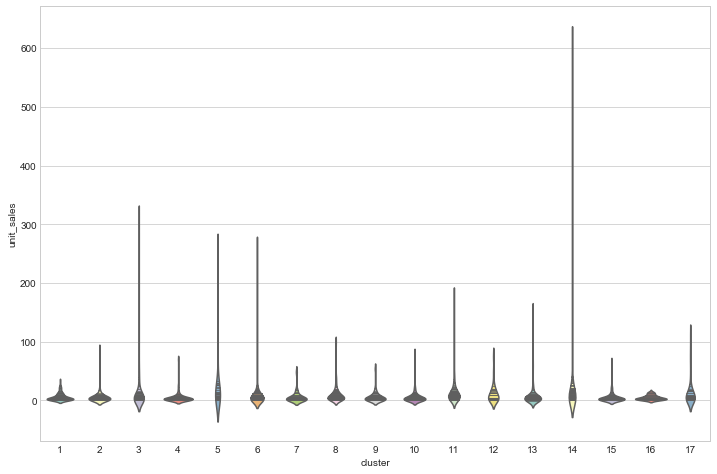

In [105]:
plt.figure(figsize=(12,8))
sns.violinplot(x="cluster",y="unit_sales", data=df_1,
              split=True, inner="stick", palette="Set3")
plt.show()

In [86]:
df_1.columns

Index([u'date', u'store_nbr', u'item_nbr', u'unit_sales', u'onpromotion',
       u'family', u'class', u'perishable', u'weekday', u'day', u'month',
       u'dayofyear', u'mean_sales', u'is_payday', u'dcoilwtico', u'city',
       u'state', u'type', u'cluster'],
      dtype='object')

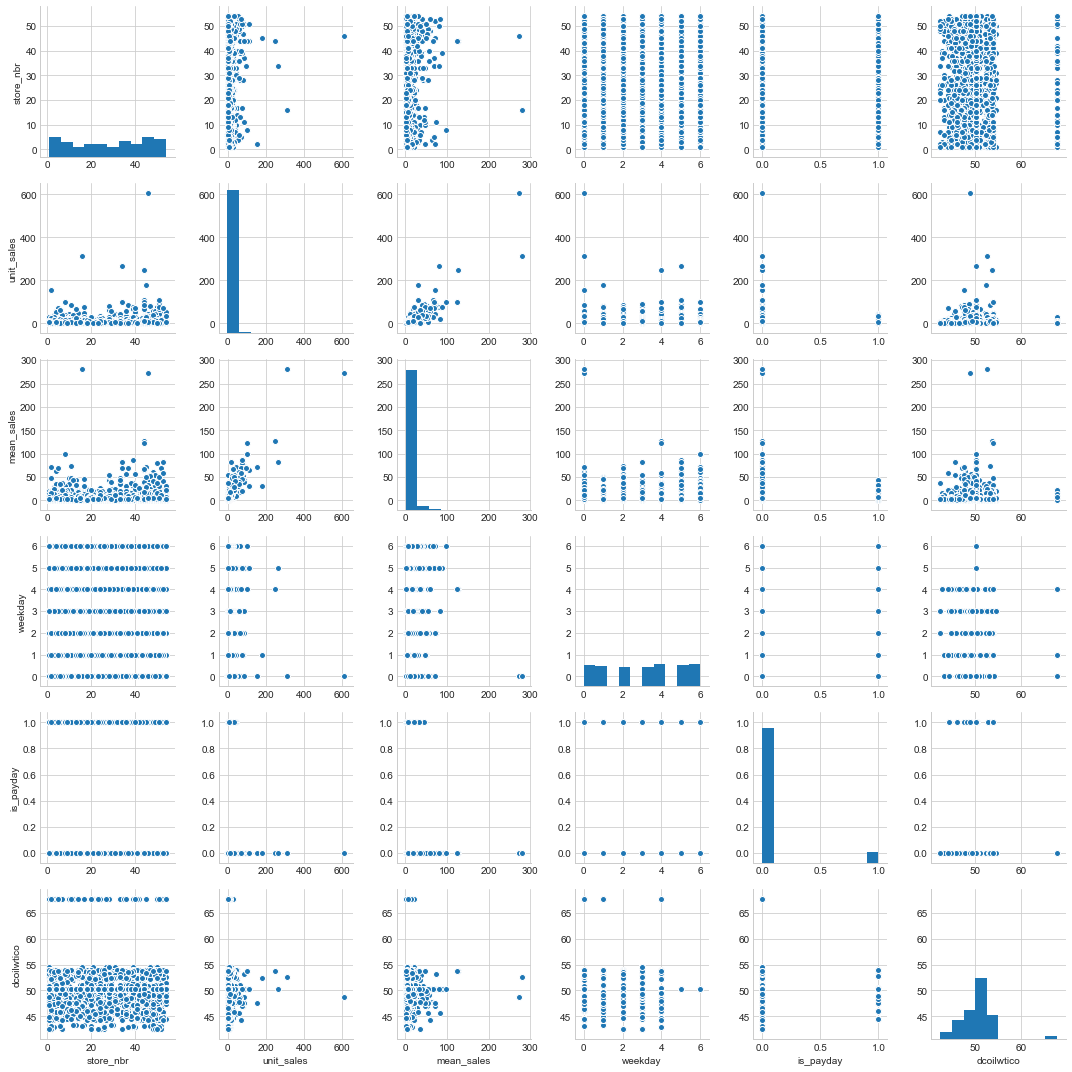

In [89]:
plt.figure(figsize=(12,8))
g = sns.pairplot(df_1[['store_nbr','unit_sales'
                       ,'mean_sales','weekday'
                       ,'is_payday','dcoilwtico']])
plt.tight_layout()
plt.show()

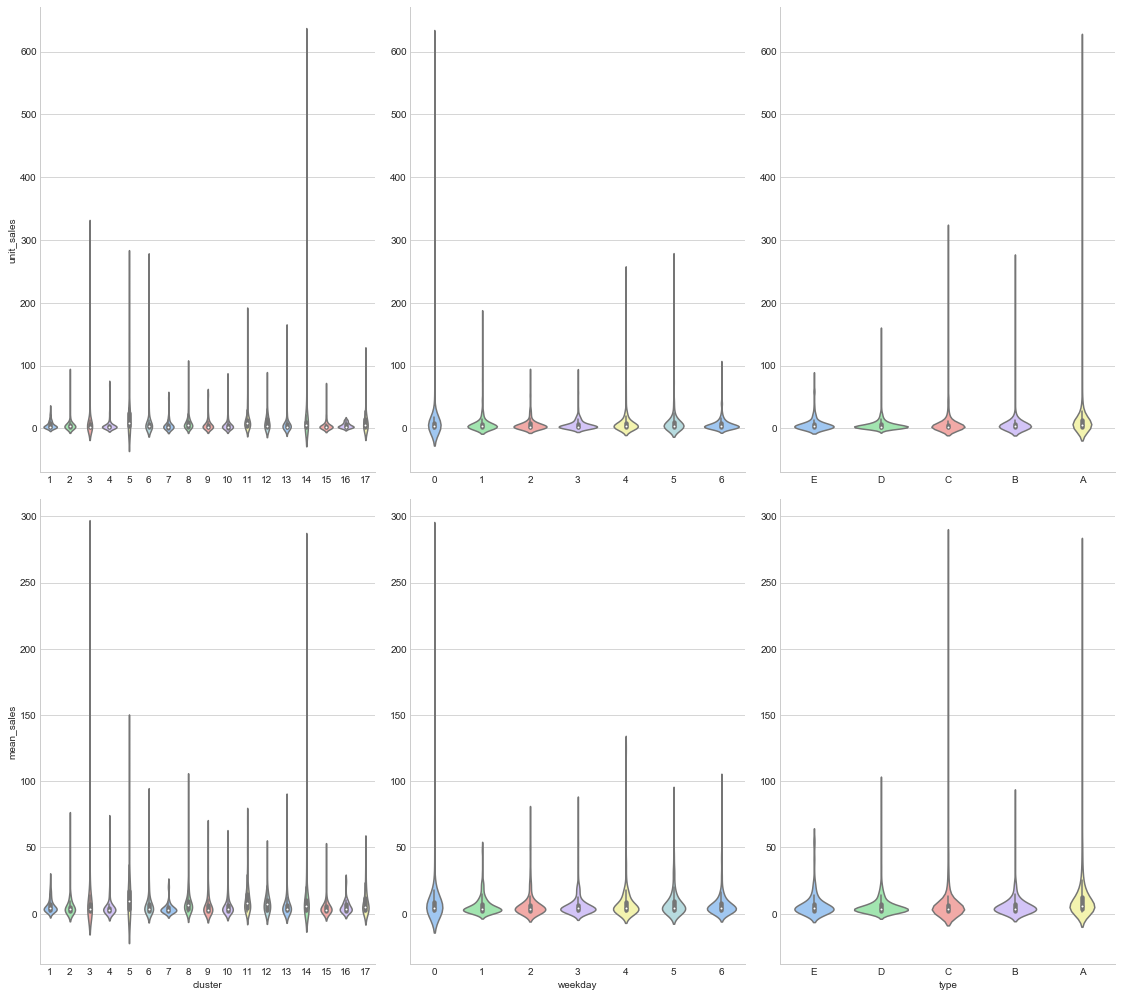

In [113]:
g = sns.PairGrid(df_1,
                 x_vars=["cluster", "weekday", "type"],
                 y_vars=["unit_sales", "mean_sales"],
                 aspect=.75, size=7)
g.map(sns.violinplot, palette="pastel");

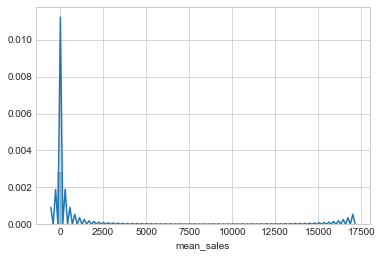

In [134]:
sns.distplot(df_2017.mean_sales)

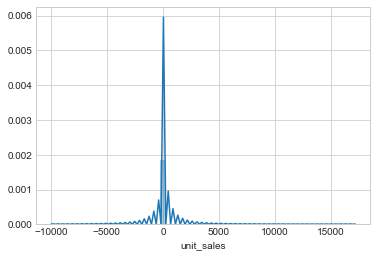

In [135]:
sns.distplot(df_2017.unit_sales)

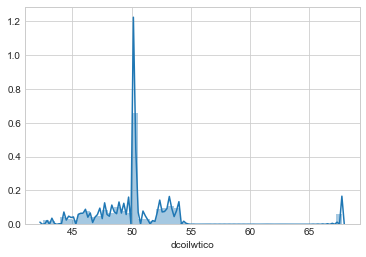

In [136]:
sns.distplot(df_2017.dcoilwtico)

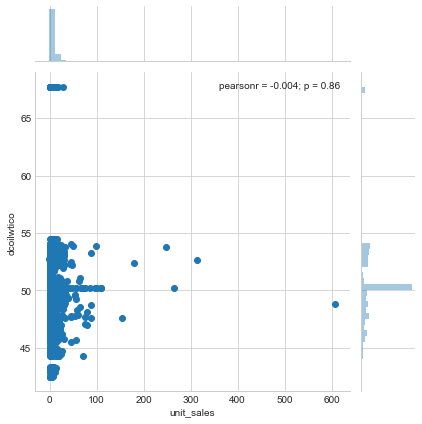

In [137]:
sns.jointplot(x=df_1.unit_sales,y=df_1.dcoilwtico,data=df_1)

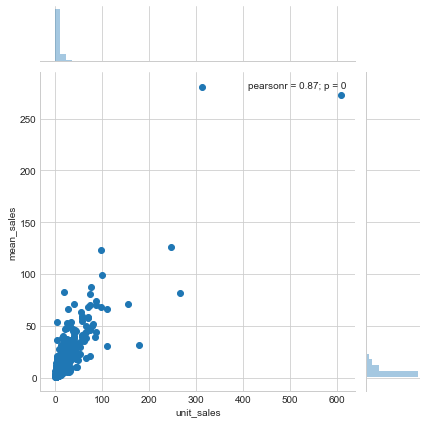

In [138]:
sns.jointplot(x=df_1.unit_sales,y=df_1.mean_sales,data=df_1)

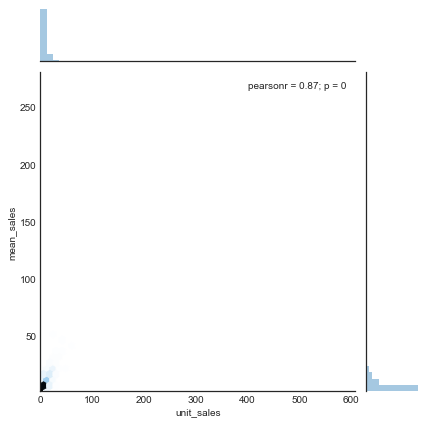

In [142]:
with sns.axes_style("white"):
    sns.jointplot(x=df_1.unit_sales,y=df_1.mean_sales,data=df_1,kind='hex')

/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/contour.py:1533: UserWarning: Warning: converting a m

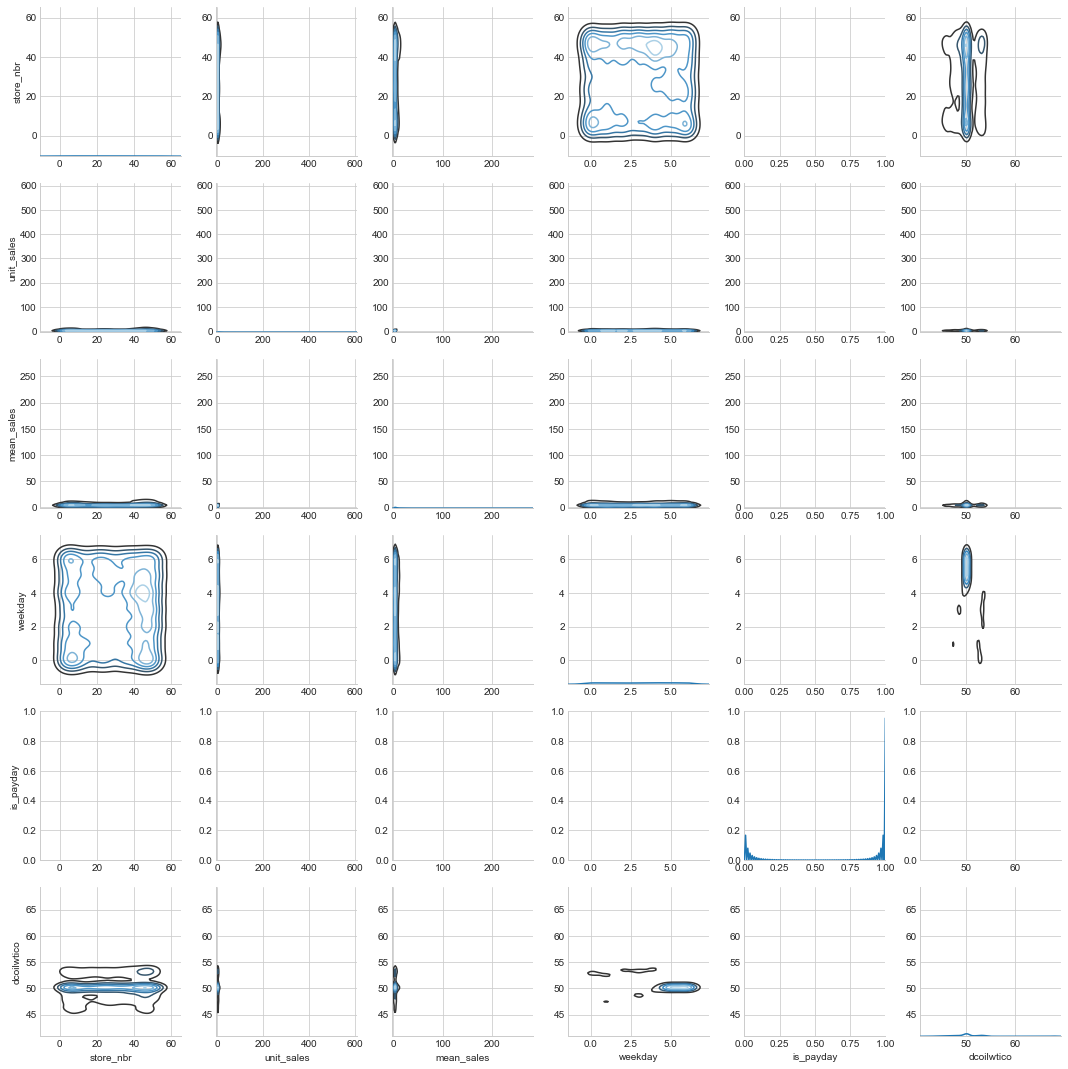

In [133]:
g = sns.PairGrid(df_1[['store_nbr','unit_sales'
                       ,'mean_sales','weekday'
                       ,'is_payday','dcoilwtico']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

Text(0,0.5,u'Oil Price')

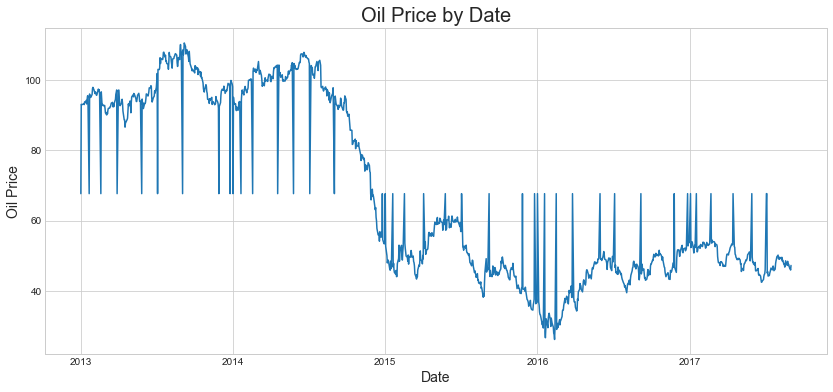

In [191]:
# set the plot size
plt.figure(figsize=(14,6))
# Create the plot title
plt.title('Oil Price by Date', fontsize=20)
# Plot total unit sales
plt.plot(oil.date, oil.dcoilwtico)

# Set the labels
plt.xlabel('Date',fontsize=14)
plt.ylabel('Oil Price',fontsize=14)

Text(0,0.5,u'Oil Price')

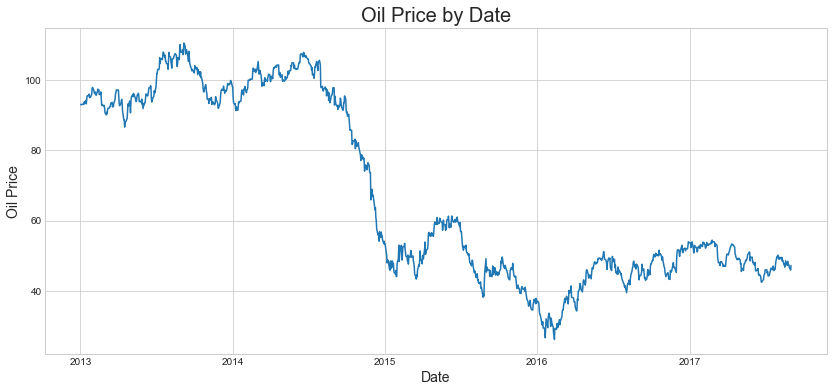

In [197]:
# set the plot size
plt.figure(figsize=(14,6))
# Create the plot title
plt.title('Oil Price by Date', fontsize=20)
# Plot total unit sales
plt.plot(oil.date, oil.dcoilwtico)

# Set the labels
plt.xlabel('Date',fontsize=14)
plt.ylabel('Oil Price',fontsize=14)

Text(0,0.5,u'# of Holiday Events')

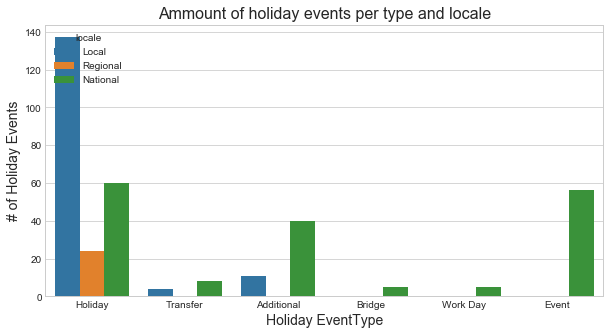

In [192]:
# Set the plot size
plt.figure(figsize=(10,5))

# Create the barplot
sns.countplot(data=hd, x='type', hue='locale')

# Set the plot title
plt.title('Ammount of holiday events per type and locale', fontsize=16)

# Set the axes labels
plt.xlabel('Holiday EventType', fontsize=14)
plt.ylabel('# of Holiday Events', fontsize=14)

In [162]:
#todo Time Series Plot

In [37]:
df_2017['id']= df_2017.index
test['id']=test.index

In [144]:
df_train=df_2017.tail(6800000)

In [145]:
df_valid=df_train.tail(3400000)

In [146]:
df_train=df_train.head(3400000)

In [103]:
test.head()

,store_nbr,item_nbr,onpromotion,class,perishable,weekday,day,month,mean_sales,is_payday,dcoilwtico,cluster,svd1,svd2,svd3,svd4,svd5,id,item_target_enc
id,,,,,,,,,,,,,,,,,,,
125497040,1,96995,0,1093,1.00,2,16,8,-4.267046e-01,0,-0.837597,13,1.813671,-0.120269,0.409539,-0.440504,0.313219,125497040,1.478952
125497041,1,99197,0,1067,1.00,2,16,8,-3.611037e-01,0,-0.837597,13,1.813671,-0.120269,0.409539,-0.440504,0.313219,125497041,3.095273
125497042,1,103501,0,3008,1.00,2,16,8,-7.121315e-17,0,-0.837597,13,1.548479,-0.434348,0.490054,-0.032467,-0.580869,125497042,4.467426
125497043,1,103520,0,1028,1.00,2,16,8,-3.208685e-01,0,-0.837597,13,1.813671,-0.120269,0.409539,-0.440504,0.313219,125497043,2.938817
125497044,1,103665,0,2712,1.25,2,16,8,-2.514989e-01,0,-0.837597,13,1.483512,-0.468483,0.488901,-0.075794,-0.419174,125497044,3.638093


# Data transformation

## Dummy variables & reducer 

In [37]:
#svd=[{'names':['item1','item2','item3','item4','item5','item6','item7','item8','item9','item10'],
#      'vars':['item_nbr'],
 #     'cmp':10},
  #   {'names':['itemb1','itemb2','itemb3','itemb4','itemb5'],
  #    'vars':['family','class'],
  #    'cmp':5},
  #   {'names':['date1','date2','date3','date4','date5'],
  #    'vars':['weekday','month', 'day'],
  #    'cmp':5},
  #   {'names':['store1','store2','store3','store4','store5'],
  #    'vars':['store_nbr','city','state','type','cluster'],
  #    'cmp':5}]

In [147]:
svd=[{'names':['svd1','svd2','svd3','svd4','svd5'],
      'vars':['family', 'city', 'state', 'type'],
      'cmp':5},
     {'names':['svd6','svd7','svd8','svd9','svd10'],
      'vars':['weekday', 'day', 'month','cluster'],
      'cmp':5}]
        
def dum_red(df):        
    for x in svd:
        reducer = TruncatedSVD(n_components=x['cmp'])
        dummy_id=df[['mean_sales']]
        for var in x['vars']:
            dummy = pd.get_dummies(df[var], prefix = var, drop_first = False)
            dummy_id = pd.concat([dummy_id, dummy], axis = 1)
            del dummy
            gc.collect()
            print var
        print "*" * 20
        dummy_id.drop('mean_sales', axis=1, inplace=True)
        dummy_id.to_csv('dummy_test_' + x['names'][0] + '.csv')
        dd = reducer.fit_transform(dummy_id)
        dd = pd.DataFrame(dd,columns=x['names'])
        dd['id']=dummy_id.index
        dd.set_index('id',inplace=True)
        dd.to_csv('test_' + x['names'][0] + '.csv')
        df = df.drop(x['vars'], axis = 1)
        df = pd.concat([df, dd], axis = 1)
        del dummy_id, dd
        gc.collect()
    return df

In [188]:
#df_valid = dum_red(df_valid)
#df_train = dum_red(df_train)
test = dum_red(test)

family
city
state
type
********************
weekday
day
month
cluster
********************


## Scale variables

In [189]:
svs = ['mean_sales','dcoilwtico']
for sv in svs:
    test[sv]=(test[sv]-test[sv].mean())/test[sv].std()
 #   df_valid[sv]=(df_valid[sv]-df_valid[sv].mean())/df_valid[sv].std()
 #   df_train[sv]=(df_train[sv]-df_train[sv].mean())/df_train[sv].std()

## Mean encoding 

In [190]:
item_id_target_mean = df_2017.groupby('item_nbr').unit_sales.mean()

#df_valid['item_target_enc'] = df_valid['item_nbr'].map(item_id_target_mean)
#df_valid['item_target_enc'].fillna(0.33343, inplace=True)

#df_train['item_target_enc'] = df_train['item_nbr'].map(item_id_target_mean)
#df_train['item_target_enc'].fillna(0.33343, inplace=True)

test['item_target_enc'] = test['item_nbr'].map(item_id_target_mean)
test['item_target_enc'].fillna(0.33343, inplace=True)


In [81]:
encoded_feature = df_valid['item_target_enc'].values
print(np.corrcoef(df_valid['unit_sales'].values, encoded_feature)[0][1])

0.414976652041


In [83]:
encoded_feature = df_train['item_target_enc'].values
print(np.corrcoef(df_train['unit_sales'].values, encoded_feature)[0][1])

0.398154892581


In [191]:
drop_col=['date','store_nbr','item_nbr','class']
#df_valid.drop(columns=drop_col, axis=1, inplace=True)
#df_train.drop(columns=drop_col, axis=1, inplace=True)
test.drop(columns=drop_col, axis=1, inplace=True)

In [126]:
#test.drop(['store_nbr','item_nbr','class','id'], axis=1, inplace=True)

In [20]:
df_train.to_csv('df_train.csv')
df_valid.to_csv('df_valid.csv')
test.to_csv('df_test.csv')

In [52]:
df_train = pd.read_csv("df_train.csv")
df_valid = pd.read_csv("df_valid.csv")
df_train.set_index('id', inplace=True)
df_valid.set_index('id', inplace=True)

In [47]:
df_valid.head()

,unit_sales,onpromotion,perishable,mean_sales,is_payday,dcoilwtico,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,item_target_enc
id,,,,,,,,,,,,,,,,,
122097040,2.0,0,1.0,-0.283618,0,-1.140223,0.416878,1.087835,-0.603168,0.105006,-0.492602,1.008556,-0.464724,0.044164,0.296894,-0.026122,7.053096
122097041,2.0,0,1.0,-0.344196,0,-1.140223,0.416878,1.087835,-0.603168,0.105006,-0.492602,1.008556,-0.464724,0.044164,0.296894,-0.026122,4.597346
122097042,2.0,0,1.0,-0.230612,0,-1.140223,0.416878,1.087835,-0.603168,0.105006,-0.492602,1.008556,-0.464724,0.044164,0.296894,-0.026122,5.833191
122097043,34.0,1,1.0,1.070738,0,-1.140223,0.416878,1.087835,-0.603168,0.105006,-0.492602,1.008556,-0.464724,0.044164,0.296894,-0.026122,7.445542
122097044,7.0,0,1.0,-0.209518,0,-1.140223,0.114186,0.639217,-0.301237,0.709437,-0.120721,1.008556,-0.464724,0.044164,0.296894,-0.026122,9.598352


In [53]:
test = pd.read_csv("df_test.csv")
test.set_index('id', inplace=True)

In [49]:
test.head()

,onpromotion,perishable,mean_sales,is_payday,dcoilwtico,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,item_target_enc,id.1
id,,,,,,,,,,,,,,,,,
125497040,0,1.00,-4.267046e-01,0,-0.837597,1.813671,-0.120268,0.409553,-0.440520,0.313100,1.171864,-0.816152,0.60066,-0.000616,-0.000092,1.478952,125497040
125497041,0,1.00,-3.611037e-01,0,-0.837597,1.813671,-0.120268,0.409553,-0.440520,0.313100,1.171864,-0.816152,0.60066,-0.000616,-0.000092,3.095273,125497041
125497042,0,1.00,-7.121315e-17,0,-0.837597,1.548480,-0.434341,0.490078,-0.032475,-0.581032,1.171864,-0.816152,0.60066,-0.000616,-0.000092,4.467426,125497042
125497043,0,1.00,-3.208685e-01,0,-0.837597,1.813671,-0.120268,0.409553,-0.440520,0.313100,1.171864,-0.816152,0.60066,-0.000616,-0.000092,2.938817,125497043
125497044,0,1.25,-2.514989e-01,0,-0.837597,1.483512,-0.468492,0.488937,-0.075873,-0.419720,1.171864,-0.816152,0.60066,-0.000616,-0.000092,3.638093,125497044


# Stacking 

In [54]:
df_train=df_train.tail(3370464)
df_valid=df_valid.head(3370464)

In [55]:
df_train['unit_sales'].fillna((df_train['unit_sales'].mean()), inplace=True)
df_valid['unit_sales'].fillna((df_valid['unit_sales'].mean()), inplace=True)

stk_X = df_train.drop('unit_sales', axis=1)
df_train['unit_sales']=df_train['unit_sales'].clip(lower=1)
#df_train['unit_sales']=df_train['unit_sales'].apply(pd.np.log1p)
stk_y = df_train['unit_sales']

valid_X = df_valid.drop('unit_sales',axis=1)
df_valid['unit_sales']=df_valid['unit_sales'].clip(lower=1)
#df_valid['unit_sales']=df_valid['unit_sales'].apply(pd.np.log1p)
valid_y = df_valid.unit_sales



In [56]:
v1=pd.DataFrame(valid_X.index)

,id
0,122097040
1,122097041
2,122097042
3,122097043
4,122097044
5,122097045
6,122097046
7,122097047
8,122097048
9,122097049


In [26]:
from time import time

## XGBoost

In [37]:
# df_train, df_valid, test
#xgboost

from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

t = time()
model = XGBRegressor()
model.fit(stk_X,stk_y)

v1_pred = model.predict(valid_X)
t1_pred = model.predict(test)


v1=pd.DataFrame(valid_X.index)
v1['xgb'] = pd.Series(v1_pred, index=v1.index)

t1=pd.DataFrame(test.index)
t1['xgb'] = pd.Series(t1_pred, index=v1.index)

model.score(stk_X,stk_y)
model.score(valid_X,valid_y)

print time() - t

131.557008028


In [38]:
#model.score(stk_X,stk_y)
#model.score(valid_X,valid_y)
v1.head(100)

,id,xgb
0,122097040,3.097917
1,122097041,2.123777
2,122097042,3.895249
3,122097043,25.263132
4,122097044,4.172259
5,122097045,2.364372
6,122097046,2.123777
7,122097047,2.256917
8,122097048,5.829364
9,122097049,2.364372


## Keras Regressor

In [58]:
df_train.shape

(3370464, 17)

In [59]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


In [60]:
seed = 7
np.random.seed(seed)

kreg = Sequential()
kreg.add(Dense(100, activation="relu", input_shape=(df_train.shape[1]-1,)))
kreg.add(Dropout(.2))
kreg.add(Dense(50, activation="relu"))
kreg.add(Dropout(.1))
kreg.add(Dense(1))
kreg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________


In [61]:
import keras
tbCallBack = keras.callbacks.TensorBoard(log_dir='/tmp/keras_logs', write_graph=True)

In [64]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=1, min_delta=10)

In [68]:
kreg.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
kreg.fit(stk_X, stk_y, epochs=40, batch_size=250000,  verbose=1, callbacks=[es])

Epoch 1/40
3370464/3370464 [==============================] - 19s 6us/step - loss: 3.2355 - mean_absolute_error: 3.2355


/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/keras/callbacks.py:494: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2267 - mean_absolute_error: 3.2267
Epoch 3/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2240 - mean_absolute_error: 3.2240
Epoch 4/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2217 - mean_absolute_error: 3.2217
Epoch 5/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2221 - mean_absolute_error: 3.2221
Epoch 6/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2219 - mean_absolute_error: 3.2219
Epoch 7/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2219 - mean_absolute_error: 3.2219
Epoch 8/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2208 - mean_absolute_error: 3.2208
Epoch 9/40
3370464/3370464 [==============================] - 17s 5us/step - loss: 3.2200 - mean_absolute_error: 3.2200
Epoch 10/40
3370464/3370464 [===========

In [122]:
kreg.predict(stk_X)

array([[ 6.80680656],
       [ 3.47189426],
       [ 4.66543245],
       ..., 
       [ 6.53892946],
       [ 5.82152176],
       [ 5.1501956 ]], dtype=float32)

In [43]:
v2 = kreg.predict(valid_X)
t2 = kreg.predict(test)

In [44]:
v2 = v2.ravel()
t2 = t2.ravel()

In [45]:
v1['kreg'] = pd.Series(v2, index=v1.index)
t1['kreg'] = pd.Series(t2, index=t1.index)

In [46]:
#ada
ada = AdaBoostRegressor()
ada.fit(stk_X,stk_y)
v3 = ada.predict(valid_X)
t3 = ada.predict(test)

In [47]:
v1['ada'] = pd.Series(v3, index=v1.index)
t1['ada'] = pd.Series(t3, index=t1.index)

In [48]:
bag = BaggingRegressor(DecisionTreeRegressor(max_depth=2),
                          n_estimators=50,
                          bootstrap=True,
                          oob_score=True, random_state=1)

In [49]:
bag.fit(stk_X,stk_y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=True,
         random_state=1, verbose=0, warm_start=False)

In [50]:
v_bag=bag.predict(valid_X)
t_bag=bag.predict(test)

In [51]:
v1['bag'] = pd.Series(v_bag, index=v1.index)
t1['bag'] = pd.Series(t_bag, index=t1.index)

In [53]:
#test.to_csv('df_test.csv')
v1.to_csv('v1.csv')
t1.to_csv('t1.csv')

In [ ]:
knn3 = KNeighborsRegressor(n_neighbors=3)
knn3.fit(stk_X, stk_y)
v_knn=knn3.predict(valid_X)
t_knn=knn3.predict(test)

In [ ]:
rf = RandomForestRegressor(n_estimators = 5, random_state=0)
rf.fit(stk_X, stk_y)
v_rf=rf.predict(valid_X)
t_rf=rf.predict(test)

In [7]:
v1 = pd.read_csv("v1.csv", index_col=0)
t1 = pd.read_csv("t1.csv", index_col=0)

/Users/eric/anaconda2/envs/tensorflow/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
t1.head()

,id,xgb,kreg,ada,bag
0,125497040,1.504415,3.241289,7.370425,5.354543
1,125497041,1.874119,3.776774,7.370425,5.354543
2,125497042,7.712440,7.469270,7.856906,5.354543
3,125497043,2.488077,4.185009,7.370425,5.354543
4,125497044,3.499866,4.886101,7.370425,5.354543


In [8]:
v1.set_index('id',inplace=True)

In [9]:
t1.set_index('id',inplace=True)

In [29]:
valid_y=valid_y.apply(pd.np.log1p)

In [12]:
v1.head()

,xgb,kreg,ada,bag
id,,,,
122097040,3.097917,4.474862,7.370425,5.354543
122097041,2.123777,3.914957,7.370425,5.354543
122097042,3.895249,5.066792,7.370425,5.354543
122097043,25.263132,22.981539,7.856906,27.240747
122097044,4.172259,5.046657,7.370425,5.354543


# Second level XGBoost

In [37]:
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(v1,valid_y)
snd_pred = model.predict(t1)
val_pred = model.predict(v1)

In [18]:
snd_pred = model.predict(t1)

In [38]:
snd_pred

array([ 1.65752637,  1.69578516,  7.88676214, ...,  7.88676214,
        7.88676214,  7.88676214], dtype=float32)

In [39]:
t2=pd.DataFrame(t1.index)
t2['unit_sales'] = pd.Series(snd_pred, index=t2.index)
#t2['unit_sales']= t2['unit_sales'].apply(pd.np.expm1)
#t2['unit_sales']= t2['unit_sales'].apply(pd.np.log1p)

In [44]:
t2['unit_sales']= t2['unit_sales'].apply(pd.np.log1p)


In [49]:
t2['unit_sales']= t2['unit_sales'].apply(pd.np.log1p)

In [50]:
t2['unit_sales']

id
125497040    0.681781
125497041    0.688983
125497042    1.158315
125497043    0.787286
125497044    0.907511
125497045    1.216280
125497046    1.329491
125497047    1.158315
125497048    0.844444
125497049    0.681781
125497050    0.907511
125497051    1.126041
125497052    0.844444
125497053    0.681781
125497054    0.681781
125497055    0.768240
125497056    0.886354
125497057    0.768240
125497058    0.907511
125497059    1.037160
125497060    1.158315
125497061    1.158315
125497062    0.863370
125497063    0.808282
125497064    1.188706
125497065    0.712919
125497066    0.886354
125497067    0.886354
125497068    1.158315
125497069    0.727853
               ...   
128867474    1.158315
128867475    1.158315
128867476    1.158315
128867477    1.158315
128867478    1.158315
128867479    1.158315
128867480    1.158315
128867481    1.158315
128867482    1.158315
128867483    1.158315
128867484    1.158315
128867485    1.158315
128867486    1.158315
128867487    1.158315
1288674

In [51]:
#t2.set_index('id', inplace=True)
t2.to_csv('submit12.csv')

In [42]:
df_train.head()

,unit_sales,onpromotion,perishable,mean_sales,is_payday,dcoilwtico,svd1,svd2,svd3,svd4,svd5,svd6,svd7,svd8,svd9,svd10,item_target_enc
id,,,,,,,,,,,,,,,,,
118726576,6.0,0,1.00,-0.060721,0,1.233282,0.422703,1.100577,-0.574748,0.087496,-0.514990,1.092593,-0.321553,-0.380435,-0.153336,0.833497,5.071158
118726577,1.0,0,1.00,-0.407531,0,1.233282,0.095074,0.655932,-0.282666,0.675958,-0.164714,1.092593,-0.321553,-0.380435,-0.153336,0.833497,2.400134
118726578,2.0,0,1.25,-0.293084,0,1.233282,0.118285,0.664422,-0.273453,0.704858,-0.150255,1.092593,-0.321553,-0.380435,-0.153336,0.833497,3.763733
118726579,4.0,0,1.25,-0.250166,0,1.233282,0.118285,0.664422,-0.273453,0.704858,-0.150255,1.092593,-0.321553,-0.380435,-0.153336,0.833497,3.690040
118726580,7.0,0,1.25,-0.215052,0,1.233282,0.118285,0.664422,-0.273453,0.704858,-0.150255,1.092593,-0.321553,-0.380435,-0.153336,0.833497,3.797306


In [48]:
NWRMSLE(valid_y,val_pred,df_valid.perishable)

0.49407349906582049